In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

%matplotlib inline

## Pre-Task: Describe the goals of your study

The goal of my study is to discover what factors influenced the survival rate of the passengers of the Titanic.

Were the chances of survival the same for everyone, or did certain groups fare better? I will use a range of models to analyse this question, determine if everyone had an equal chance, and determine what were the important factors in survival if that wasn't the case.

I will use this study to develop and showcase data science skills, using a variety of techniques to both impute missing data and create new features,, then apply models to answer the question above.

The null hypothesis underpinning this project is that each passenger on the Titanic was equally likely to live.

## Part 1: Aquire the Data

<https://www.kaggle.com/c/titanic>

In [2]:
titanic_df = pd.read_csv("assets/train.csv")

In [3]:
# Check the header of the new dataframe:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Part 2: Exploratory Data Analysis

#### 1. Describe the Data

In [4]:
titanic_df.shape

(891, 12)

In [5]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Right now we only have six functional numeric fields - this will need to be increased for the logistic regression modelling, by converting text data to numeric and dummy fields, and creating new features.

First, are there any blank cells in the dataframe?

In [6]:
titanic_df.isnull().values.any()

True

There are blank data cells. Let's see where:

In [7]:
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Age, Cabin and Embarked will need to be imputed, or removed as columns.

In [8]:
# Let's check headline survival stats in the dataset, to begin to establish a baseline:
titanic_df['Survived'].value_counts(dropna=False)

0    549
1    342
Name: Survived, dtype: int64

In [9]:
titanic_df['Survived'].value_counts(dropna=False) / titanic_df.shape[0]
#baseline calculation will be the % chance of the most frequest event.

0    0.616162
1    0.383838
Name: Survived, dtype: float64

The baseline accuracy any model will be judged against is 62% - the chance of picking a none surviving passenger at random.

Let's start imputing missing data, first off the easiest - the two missing Embarked chars

In [10]:
titanic_df[titanic_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Researching the matter online :

62 embarked in Southampton

https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html

830 also embarked in Southampton

<https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html>

Let's input the two missing values with Southampton, which is both the modal value, and the correct one in both cases here:

In [11]:
print titanic_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [12]:
#DataFrame.fillna(value=None, method=None, axis=None, inplace=False, limit=None, downcast=None, **kwargs)¶
titanic_df['Embarked'].fillna(value='S',inplace=True)

In [13]:
print titanic_df[titanic_df['Embarked'].isnull()]

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []


Class is the next column across - lets see if there are any missing values:

In [14]:
titanic_df['Pclass'].value_counts(dropna=False)

3    491
1    216
2    184
Name: Pclass, dtype: int64

No missing values - great! As this could be a decisive variable (going by some of the subplots of the movie!) let's check headline figures of the survival rates per class:

In [15]:
survived_table = pd.pivot_table(titanic_df[['Survived','Pclass']], index='Pclass', columns='Survived', aggfunc=lambda x: len(x))

survived_table['perished %'] = survived_table[0] / (survived_table[0] + survived_table[1])
survived_table['survived %'] = survived_table[1] / (survived_table[0] + survived_table[1])

print survived_table

Survived    0    1  perished %  survived %
Pclass                                    
1          80  136    0.370370    0.629630
2          97   87    0.527174    0.472826
3         372  119    0.757637    0.242363


So, survival rates increased as the ticket class increased - this will likely guide and impact our models.

Next up, names. Perhaps there is value we can extract from within this free text field?

In [16]:
titanic_df['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

The format is surname *comma* title *full stop* first name middle name, then possibly extra detail in brackets.

In [17]:
def return_title(input_name):
    title_text = input_name[input_name.index(",")+2:input_name.index(".")]
    return title_text

def return_surname(input_name):
    surname_text = input_name[0:input_name.index(",")]
    return surname_text

Adding title and surname fields, adding features, and also potentially give insight into missing ages..

In [18]:
titanic_df['Title'] = titanic_df['Name'].apply(return_title)
titanic_df['Surname'] = titanic_df['Name'].apply(return_surname)

Let's see what the result of the title extraction was :

In [19]:
titanic_df['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Lady              1
Jonkheer          1
Don               1
Ms                1
Mme               1
Capt              1
the Countess      1
Sir               1
Name: Title, dtype: int64

Mr, Miss, Mrs are all defined by the gender field, Master is a sum of the gender field and age, but the other fields potentially denote status and could offer value..

Also in name is the surname - perhaps grouping by count of matching surnames could offer value into the survivability of larger groups?

In [20]:
titanic_df['Surname'].value_counts().head(10)

Andersson     9
Sage          7
Carter        6
Goodwin       6
Skoog         6
Panula        6
Johnson       6
Rice          5
Lefebre       4
Gustafsson    4
Name: Surname, dtype: int64

The tale of the Anderssons is a sad one - a whole family of seven died.

<https://titanicstory.wordpress.com/2012/04/04/the-entire-andersson-family-was-lost-on-the-titanic/>

In [21]:
titanic_df[titanic_df['Surname'] == 'Andersson']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S,Mr,Andersson
68,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,NaN,S,Miss,Andersson
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,S,Miss,Andersson
146,147,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S,Mr,Andersson
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.2750,NaN,S,Miss,Andersson
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.2750,NaN,S,Miss,Andersson
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S,Mrs,Andersson
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,Miss,Andersson
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.2750,NaN,S,Master,Andersson


Here the 'SibSp & Parch' values don't fully make sense - each row (other than August) has a count of six, which plus the person of the row is seven, which is the number of members of the family. But, __eight__ rows have the count of six + one, meaning someone has been misallocated to the Andersson family (Erna Alexandra), or, the count of the family is incorrect. I believe it is the former.

I will take the count of surnames, as well as the sum of SibSp & Parch, and see if either holds more weight as a predictor.

In [22]:
pd.Series(titanic_df['Surname'].value_counts().values).value_counts()

1    534
2     83
3     28
4     14
6      5
9      1
7      1
5      1
dtype: int64

The vast majority of surnames only featured once - these none-married individuals could have a different survival rating:

In [23]:
name_match_size_lookup = titanic_df['Surname'].value_counts()

In [24]:
titanic_df['Name_match_size'] = titanic_df['Surname'].apply(lambda x: name_match_size_lookup[x])

In [25]:
name_match_table = pd.pivot_table(titanic_df[['Survived','Name_match_size']], index='Name_match_size', columns='Survived', fill_value=0, aggfunc=lambda x: len(x))

name_match_table['perished %'] = name_match_table[0] / (name_match_table[0] + name_match_table[1])
name_match_table['survived %'] = name_match_table[1] / (name_match_table[0] + name_match_table[1])

print name_match_table

Survived           0    1  perished %  survived %
Name_match_size                                  
1                342  192    0.640449    0.359551
2                 79   87    0.475904    0.524096
3                 54   30    0.642857    0.357143
4                 32   24    0.571429    0.428571
5                  5    0    1.000000    0.000000
6                 23    7    0.766667    0.233333
7                  7    0    1.000000    0.000000
9                  7    2    0.777778    0.222222


According to the numbers above, people with a unique sirname (suggesting individual travellers) had a much worse survival rating than say couples, however, this could represent individual migrators travelling on cheaper tickets, and have a lot of colinearity with say Pclass

Let's break these groupings down into smaller categories:

In [26]:
surname_counts = pd.Series(titanic_df['Surname'].value_counts())

def return_surname_count_status(input_surname):
    surname_count = surname_counts[input_surname]
    if surname_count == 1:
        return 'Solo'
    elif surname_count == 2:
        return 'Couple'
    elif surname_count > 2:
        return 'Family'
    
titanic_df['Surname_count_status'] = titanic_df['Surname'].apply(return_surname_count_status)

In [27]:
group_table = pd.pivot_table(titanic_df[['Survived','Surname_count_status']], index='Surname_count_status', columns='Survived', aggfunc=lambda x: len(x))

group_table['perished %'] = group_table[0] / (group_table[0] + group_table[1])
group_table['survived %'] = group_table[1] / (group_table[0] + group_table[1])


print group_table

Survived                0    1  perished %  survived %
Surname_count_status                                  
Couple                 79   87    0.475904    0.524096
Family                128   63    0.670157    0.329843
Solo                  342  192    0.640449    0.359551


So, couple's win out again, but, lets be weary that couples could be recreational travellers on more expensive tickets

Although I'm sceptical about the SibSp and Parch fields, let's combine them, just in case the additional feature has value (and/or, can beat the new feature above)

In [28]:
titanic_df['Family_size'] = titanic_df['SibSp'] + titanic_df['Parch']

Could we possibly infer status from the name titles?

How do titles compare to tickets?

In [29]:
titanic_df['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Lady              1
Jonkheer          1
Don               1
Ms                1
Mme               1
Capt              1
the Countess      1
Sir               1
Name: Title, dtype: int64

In [30]:
pd.pivot_table(titanic_df[['Title','Pclass']], index='Title', columns='Pclass', aggfunc=lambda x: len(x))

Pclass,1,2,3
Title,,,
Capt,1.0,NaN,NaN
Col,2.0,NaN,NaN
Don,1.0,NaN,NaN
Dr,5.0,2.0,NaN
Jonkheer,1.0,NaN,NaN
Lady,1.0,NaN,NaN
Major,2.0,NaN,NaN
Master,3.0,9.0,28.0
Miss,46.0,34.0,102.0


The newly seperated features seem to correlate with higher ticket classes, as expected, so might not have too much value.. However, let's continue with the feature development

In [31]:
for title in titanic_df['Title'].unique():
    print title

Mr
Mrs
Miss
Master
Don
Rev
Dr
Mme
Ms
Major
Lady
Sir
Mlle
Col
Capt
the Countess
Jonkheer


Because some titles are very infrequent, lets group them together into a binary 'Status' feature:

In [32]:
titles_dict = {
'Mr':0,
'Mrs':0,
'Miss':0,
'Master':0,
'Don':1,
'Rev':1,
'Dr':1,
'Mme':1,
'Ms':0,
'Major':1,
'Lady':1,
'Sir':1,
'Mlle':1,
'Col':1,
'Capt':1,
'the Countess':1,
'Jonkheer':1
}

And apply it to the DF:

In [33]:
titanic_df['Status'] = titanic_df['Title'].apply(lambda x: titles_dict[x])

And check how it compares to the ticket class:

In [34]:
pd.pivot_table(titanic_df[['Status','Pclass']], index='Status', columns='Pclass', aggfunc=lambda x: len(x))

Pclass,1,2,3
Status,,,
0,198.0,176.0,491.0
1,18.0,8.0,NaN


And survivability (per title, and overall):

In [35]:
pd.pivot_table(titanic_df[['Status','Title']], index='Title', columns='Status', fill_value=0, aggfunc=lambda x: len(x))

Status,0,1
Title,,
Capt,0,1
Col,0,2
Don,0,1
Dr,0,7
Jonkheer,0,1
Lady,0,1
Major,0,2
Master,40,0
Miss,182,0


In [36]:
status_table = pd.pivot_table(titanic_df[['Survived','Status']], index='Status', columns='Survived', aggfunc=lambda x: len(x))

status_table['perished %'] = status_table[0] / (status_table[0] + status_table[1])
status_table['survived %'] = status_table[1] / (status_table[0] + status_table[1])


print status_table

Survived    0    1  perished %  survived %
Status                                    
0         534  331    0.617341    0.382659
1          15   11    0.576923    0.423077


Status field doesn't seem to be as strong an indicator of survival as other present or calculated fields

Next field to contend with is Cabin:

In [37]:
titanic_df['Cabin'].value_counts(dropna=False).head()

NaN            687
G6               4
C23 C25 C27      4
B96 B98          4
F2               3
Name: Cabin, dtype: int64

Which can come in a number of formats, with the majority missing.

Because the text is so varied, and the key value in it is the deck, which is connected to the first character of the cabin, lets break it out to just missing, or the first letter/deck, so it can be dummied later:

In [38]:
def return_cabin_letter(input_cabin):
    if pd.isnull(input_cabin):
        return "U"
    else:
        return str(input_cabin)[0]

titanic_df['Cabin_letter'] = titanic_df['Cabin'].apply(return_cabin_letter)

In [39]:
cabin_letter_table = pd.pivot_table(titanic_df[['Survived','Cabin_letter']], index='Cabin_letter', columns='Survived', fill_value=0, aggfunc=lambda x: len(x))

cabin_letter_table['perished %'] = cabin_letter_table[0] / (cabin_letter_table[0] + cabin_letter_table[1])
cabin_letter_table['survived %'] = cabin_letter_table[1] / (cabin_letter_table[0] + cabin_letter_table[1])

print cabin_letter_table

print titanic_df['Survived'].value_counts() / titanic_df.shape[0]

Survived        0    1  perished %  survived %
Cabin_letter                                  
A               8    7    0.533333    0.466667
B              12   35    0.255319    0.744681
C              24   35    0.406780    0.593220
D               8   25    0.242424    0.757576
E               8   24    0.250000    0.750000
F               5    8    0.384615    0.615385
G               2    2    0.500000    0.500000
T               1    0    1.000000    0.000000
U             481  206    0.700146    0.299854
0    0.616162
1    0.383838
Name: Survived, dtype: float64


So, we see A through G all over indexing in survivability versus the baseline.

This will likely be key to the model when dummied.

To double check the relevance of this, let's check if the Titanic crashed late at night, meaning people were more likely to be in the cabins, and thus cabin location was particularly important?

"The Titanic struck the iceberg at 11:40 pm on April 14, 1912. The Titanic sank 2 hours and 40 minutes later at 2:20 am on April 15, 1912.3 Apr 2012"
        
<https://awesometalks.wordpress.com/2012/04/03/what-time-did-the-rms-titanic-really-hit-the-iceberg/>

Although, the exact time is still disputed, the impact of cabin location to survivability is clear. Cabin location and ticket class will have colinearity, will be interesting to see how they compare later...

Not all tickets have cabin info, but all tickets have class info. I assume the 'U' tickets are disproportionately 3rd class?

In [40]:
print titanic_df[titanic_df['Cabin_letter'] == 'U']['Pclass'].value_counts() / titanic_df.shape[0]

3    0.537598
2    0.188552
1    0.044893
Name: Pclass, dtype: float64


In [41]:
print titanic_df['Pclass'].value_counts() / titanic_df.shape[0]

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64


The answer is yes - missing cabin information is disproportionately prevelent in lower class tickets, so, we'll monitor the interaction between the features later.

In [42]:
titanic_df[titanic_df['Cabin_letter'].apply(lambda x: True if x != 'U' else False)]['Pclass'].value_counts(sort=False)

1    176
2     16
3     12
Name: Pclass, dtype: int64

In [43]:
titanic_df[titanic_df['Cabin_letter'].apply(lambda x: True if x == 'U' else False)]['Pclass'].value_counts(sort=False)

1     40
2    168
3    479
Name: Pclass, dtype: int64

'U' seems to be shorthand for lower tier ticket. Likely to be lots of colinearity with ticket class, but, lets keep it for now

Age is the next feature to contend with, with many missing values. First, lets sense check the values there:

In [44]:
pd.pivot_table(titanic_df[['Age','Survived']], index='Age', columns='Survived', aggfunc=lambda x: len(x)).head()

Survived,0,1
Age,,
0.42,NaN,1.0
0.67,NaN,1.0
0.75,NaN,2.0
0.83,NaN,2.0
0.92,NaN,1.0


Are sub 1 ages babies, or data issues?

In [45]:
titanic_df[titanic_df['Age'] < 1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,Name_match_size,Surname_count_status,Family_size,Status,Cabin_letter
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S,Master,Caldwell,2,Couple,2,0,U
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,Master,Allison,3,Family,3,0,C
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C,Miss,Baclini,4,Family,3,0,U
644,645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C,Miss,Baclini,4,Family,3,0,U
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S,Master,Hamalainen,2,Couple,2,0,U
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C,Master,Thomas,1,Solo,1,0,U
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S,Master,Richards,3,Family,2,0,U


The 'master' in the names of the males is consistent with the data - master being the prefix of a young, unmarried male.

To check further, Googled all names, all were young babied (and, fortunately all survived).



Let's look at survivability per age, to see if there are any overall trends:

In [46]:
survived_per_age = pd.pivot_table(titanic_df[['Age','Survived']], index='Age', columns='Survived', fill_value=0, aggfunc=lambda x: len(x))

In [47]:
def calc_survival(input_row):
    print input_row.iloc[0,:]
    if input_row.iloc[:0] is None:
        return 1
    elif input_row.iloc[:0] is None:
        return 0
    else:
        return input_row.iloc[1:] / ( input_row.iloc[0:] + input_row.iloc[1:] )
    #print input_row.iloc[0:]

In [48]:
survived_per_age['Survived_perc'] = 0.0
survived_per_age['Survived_perc'] = survived_per_age.apply(lambda x: 1. if x[0] == 0 else 0. if x[1] == 0 else (x[1]/(x[0]+x[1])), axis=1)

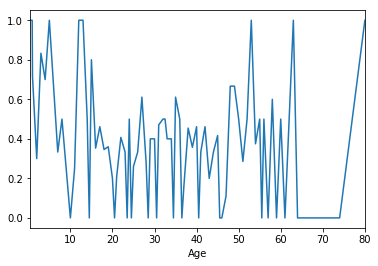

In [49]:
survived_per_age['Survived_perc'].plot()

Overall, the data is very jumpy (due to certain ages having few people). There seems to be a downward trend overall though. Let's combine ages into buckets to see if the trends become clearer:

In [51]:
age_survived = titanic_df[['Age','Survived']]
age_range = range(0,100,5)
age_names = [str(age) +  " < age <= " + str(age + 5) for age in age_range[0:-1]]
age_survived['Age_grouped_5'] = pd.cut(titanic_df['Age'], age_range, labels = age_names)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [52]:
age_survived.dropna(inplace=True)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [53]:
age_survived_grouped = pd.pivot_table(age_survived[['Age_grouped_5','Survived']],index = 'Age_grouped_5',columns='Survived', fill_value=0, aggfunc=lambda x: len(x))

In [54]:
age_survived_grouped['Survived_perc'] = 0.0
age_survived_grouped['Survived_perc'] = age_survived_grouped.apply(lambda x: 0. if x[1] == 0 else 1. if x[0] == 0 else x[1]/(x[0]+x[1]), axis=1)

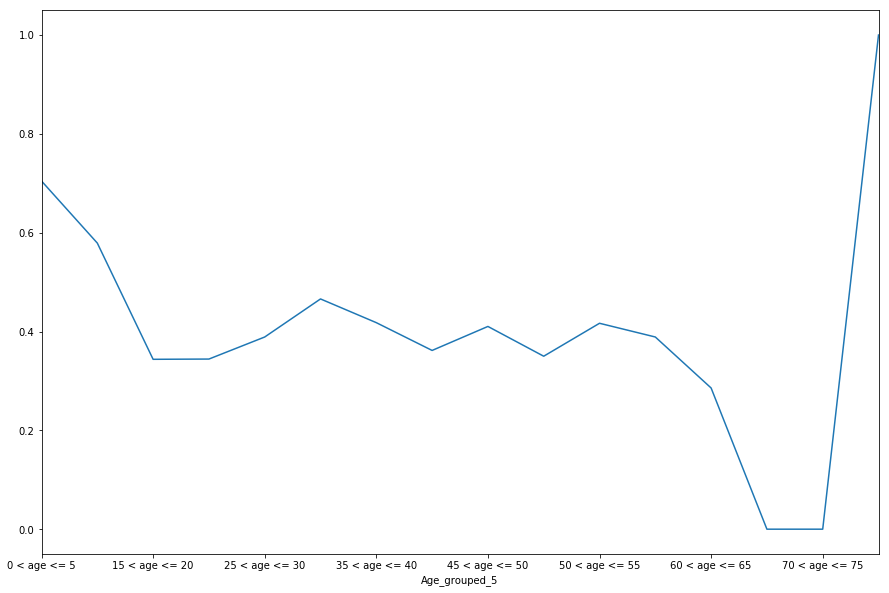

In [55]:
age_survived_grouped['Survived_perc'].plot(figsize=(15,10))

In [56]:
age_survived_grouped.head(6)

Survived,0,1,Survived_perc
Age_grouped_5,,,
0 < age <= 5,13,31,0.704545
10 < age <= 15,8,11,0.578947
15 < age <= 20,63,33,0.343750
20 < age <= 25,80,42,0.344262
25 < age <= 30,66,42,0.388889
30 < age <= 35,47,41,0.465909


Overall we see the 0 < age <= 5 doing well, as you would hope, but after 10 things are relatively flat.

I'm not sure if creating a <10 category for children would be valuable, or, if the standardised age will capture that in regression?

The simplest method of impution would be the mean or median, let's look at those:

In [57]:
print("Mean: ",titanic_df['Age'].mean())
print("Median: ",titanic_df['Age'].median())

('Mean: ', 29.69911764705882)
('Median: ', 28.0)


If we break down by gender do those numbers change, and become more accurate?

In [58]:
print titanic_df.groupby(['Sex']).mean()['Age']
print titanic_df.groupby(['Sex']).median()['Age']

Sex
female    27.915709
male      30.726645
Name: Age, dtype: float64
Sex
female    27.0
male      29.0
Name: Age, dtype: float64


What about gender, ticket class and survival?

In [59]:
grouped = titanic_df.groupby(['Sex','Pclass','Survived'])
print grouped['Age'].median()
print grouped['Age'].count()

Sex     Pclass  Survived
female  1       0           25.0
                1           35.0
        2       0           32.5
                1           28.0
        3       0           22.0
                1           19.0
male    1       0           45.5
                1           36.0
        2       0           30.5
                1            3.0
        3       0           25.0
                1           25.0
Name: Age, dtype: float64
Sex     Pclass  Survived
female  1       0             3
                1            82
        2       0             6
                1            68
        3       0            55
                1            47
male    1       0            61
                1            40
        2       0            84
                1            15
        3       0           215
                1            38
Name: Age, dtype: int64


As the categories are broken down more, the data potentially comes more precise, it starts to become a variance / bias trade off...

The code to impute the missing ages based on these categories is below, but I ended up taking a different route..

In [60]:
# CODE TO AUTOFILL BASED ON SEX/CLASS

# missing_ages = titanic_df[titanic_df['Age'].isnull()]
# # determine mean age based on Sex and Pclass
# mean_ages = titanic_df.groupby(['Sex','Pclass'])['Age'].mean()

# def remove_na_ages(row):
#     '''
#     function to check if the age is null and replace wth the mean from 
#     the mean ages dataframe 
#     '''
#     if pd.isnull(row['Age']):
#         return mean_ages[row['Sex'],row['Pclass']]
#     else:
#         return row['Age']

# titanic_df['Age'] = titanic_df.apply(remove_na_ages, axis=1)


As the missing data does exist online, lets try to scrape it from a more comprehensive source, and include it into the dataframe!

Firstly, lets download a webpage with all the ages:

In [61]:
from bs4 import BeautifulSoup
import requests

r = requests.get('http://www.titanicfacts.net/titanic-passenger-list.html')

soup = BeautifulSoup(r.text, 'html.parser')

And scrape the names and ages:

In [62]:
ext_name_dict = {}

#def removeNonAscii(s): return "".join(i for i in s if ord(i)<128)

tables = soup.find_all("table", width="100%")

for tr in tables:
    for row in tr.find_all('tr'):
        if row.find("td", { "class" : "surname" }):
            #print row        
            name = row.find_all('td')[0].text + ", " + row.find_all('td')[1].text
            #name = removeNonAscii(name)
            #name = name.encode('ascii','replace')
            #name = name.replace("??",' ')
            name = name.encode('utf-8')
            name = name.replace("Â",'')
            name = str(name)
            age = row.find_all('td')[2].text
            ext_name_dict[name] = age

Next up, we need to match the names between the two sources, which won't be a simple binary match due to the complexity of the data (e.g. names, titles, international spellings etc).

To calculate the best matches, let's use the Levenshtein distance:

In [64]:
import editdistance

#Here is an example, with a simple discreprancy (a missing full stop):
editdistance.eval('Sutehall, Mr. Henry Jr', 'Sutehall, Mr Henry Jr')

1L

Now, lets find the best match for each name in the dataframe missing an age.

The internal workings of the code look something like this:

In [65]:
#864 Sage, Miss. Dorothy Edith "Dolly" |Myhrman, Mr Pehr Fabian Oliver Malkolm 33
#864 Sage, Miss. Dorothy Edith "Dolly" |Coutts, Master Neville Leslie 28
#864 Sage, Miss. Dorothy Edith "Dolly" |Compton, Miss Sara Rebecca 27
#864 Sage, Miss. Dorothy Edith "Dolly" |Nasser, Mrs Adele 27
#864 Sage, Miss. Dorothy Edith "Dolly" |Allen, Mr William Henry 26
#864 Sage, Miss. Dorothy Edith "Dolly" |Toomey, Miss Ellen Mary 25
#864 Sage, Miss. Dorothy Edith "Dolly" |Eustis, Miss Elizabeth Mussey 24
#864 Sage, Miss. Dorothy Edith "Dolly" |Rosenbaum, Miss Edith Louise 23
#864 Sage, Miss. Dorothy Edith "Dolly" |Gibson, Miss Dorothy Winifred 19
#864 Sage, Miss. Dorothy Edith "Dolly" |Sage, Miss Dorothy 16

In [66]:
names_with_no_age = pd.DataFrame(titanic_df[titanic_df['Age'].isnull()]['Name'])

Name = "Petroff, Mr. Pastcho (\"Pentcho\")"
Name = Name.replace(".",'')

closest_match_dict = {}

for PassengerID, Name in names_with_no_age.iterrows():
    closest_match_score = 1000
    for name, age in ext_name_dict.iteritems():
        if int(str(editdistance.eval(Name[0].replace(".",""), name))) < closest_match_score:
            closest_match_score = int(str(editdistance.eval(Name[0], name)))
            #print PassengerID, Name[0], "|" + name, closest_match_score
            closest_match_dict[PassengerID] = age

Now, with best matches found, lets apply the matches ages to the dataframe:

In [67]:
for idx, age in closest_match_dict.iteritems():
    #DataFrame.set_value(index, col, value, takeable=False)
    titanic_df.set_value(idx, 'Age', int(age))

In [68]:
titanic_df.isnull().sum()

PassengerId               0
Survived                  0
Pclass                    0
Name                      0
Sex                       0
Age                       0
SibSp                     0
Parch                     0
Ticket                    0
Fare                      0
Cabin                   687
Embarked                  0
Title                     0
Surname                   0
Name_match_size           0
Surname_count_status      0
Family_size               0
Status                    0
Cabin_letter              0
dtype: int64

Now, all data is imputed, apart from the missing cabins which will be dropped, and replaced with a 'cabin letter' dummy. Lets see if any other features can be created.

The 'Ticket' field is another one with some extremely difficult to parse, inconsistent data, but, perhaps the number of tickets could signify a group, and thus create value?

In [69]:
ticket_counts = titanic_df['Ticket'].value_counts()

In [70]:
titanic_df['Ticket_count'] = np.NaN

In [71]:
for idx,val in ticket_counts.iteritems():
    titanic_df.loc[titanic_df['Ticket'] == idx, 'Ticket_count'] = val

In [72]:
titanic_df[titanic_df['Ticket_count']>1][['Name','Pclass','Ticket','Fare','Ticket_count']].sort_values(by='Ticket').head(6)

,Name,Pclass,Ticket,Fare,Ticket_count
257,"Cherry, Miss. Gladys",1,110152,86.50,3.0
759,"Rothes, the Countess. of (Lucy Noel Martha Dye...",1,110152,86.50,3.0
504,"Maioni, Miss. Roberta",1,110152,86.50,3.0
262,"Taussig, Mr. Emil",1,110413,79.65,3.0
558,"Taussig, Mrs. Emil (Tillie Mandelbaum)",1,110413,79.65,3.0
585,"Taussig, Miss. Ruth",1,110413,79.65,3.0


Now, all ticket groups are captured by the ticket_count variable.

The next question is whether ticket price is for the ticket, or the set of tickets?

Let's create a price per ticket feature, from the ticket_count and fare, if this is the case.

In [73]:
titanic_df['Fare_per_ticket'] = titanic_df['Fare'] / titanic_df['Ticket_count']

In [74]:
print titanic_df.groupby(['Pclass']).mean()['Fare']
print titanic_df.groupby(['Pclass']).mean()['Fare_per_ticket']

Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64
Pclass
1    43.650347
2    13.322599
3     8.085857
Name: Fare_per_ticket, dtype: float64


Lets see, when normalised, if one has a stronger connection to survival.

It would be interesting to model prices in inflation adjusted sterling, which would be more interpretable, but, mathematically, as all the values will be normalised, there would be no statistical impact on the model.

In [75]:
# turn gender into numeric
titanic_df['Male'] = titanic_df['Sex'].map({'male':1,'female':0})

In [76]:
# check if it worked:
titanic_df[['Name','Sex','Male']].head(3)

,Name,Sex,Male
0,"Braund, Mr. Owen Harris",male,1
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0
2,"Heikkinen, Miss. Laina",female,0


In [77]:
# Quick check to see the dataframe we are now working with :
titanic_df.head(2).T

,0,1
PassengerId,1,2
Survived,0,1
Pclass,3,1
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th..."
Sex,male,female
Age,22,38
SibSp,1,1
Parch,0,0
Ticket,A/5 21171,PC 17599
Fare,7.25,71.2833


Lots of text data left in the dataframe, which has been transformed into other columns. Lets clean this up:

In [78]:
# create new df to manipulate
intermediate_df = titanic_df

In [79]:
# prepping the dummy data so the most logical, impactful value is the missing default

# southampton as the departure point (most frequent)
# solo as a surname count status (logical and most frequent)
# U as the cabin letter (most frequent, and logical as U means missing) 

intermediate_df.loc[titanic_df['Embarked'] == 'S','Embarked'] = None
intermediate_df.loc[titanic_df['Surname_count_status'] == 'Solo','Surname_count_status'] = None
intermediate_df.loc[titanic_df['Cabin_letter'] == 'U','Cabin_letter'] = None

In [80]:
columns = ['index', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title',
       'Surname', 'Name_match_size', 'Surname_count_status', 'Family_size',
       'Status', 'Cabin_letter', 'Ticket_count', 'Fare_per_ticket', 'Male']

target_column = ['Survived']

numeric_columns = ['Pclass','Age', 'SibSp',
       'Parch', 'Fare', 'Name_match_size', 'Family_size',
       'Status', 'Ticket_count', 'Fare_per_ticket', 'Male']

columns_to_dummy = ['Embarked','Surname_count_status','Cabin_letter']

In [81]:
# lets check nothing is missing :

remaining_columns = [col for col in columns if col not in target_column]
remaining_columns = [col for col in remaining_columns if col not in numeric_columns]
remaining_columns = [col for col in remaining_columns if col not in columns_to_dummy]

print remaining_columns

print len(columns)
print len(target_column) + len(numeric_columns) + len(columns_to_dummy) + len(remaining_columns)

['index', 'Name', 'Sex', 'Ticket', 'Cabin', 'Title', 'Surname']
22
22


In [82]:
# lets create the dummy columns, and check the first values:

dummy_columns = pd.get_dummies(titanic_df[columns_to_dummy],drop_first=False)

#pandas.get_dummies(data, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False)
print dummy_columns.head(2).T

                             0  1
Embarked_C                   0  1
Embarked_Q                   0  0
Surname_count_status_Couple  1  0
Surname_count_status_Family  0  0
Cabin_letter_A               0  0
Cabin_letter_B               0  0
Cabin_letter_C               0  1
Cabin_letter_D               0  0
Cabin_letter_E               0  0
Cabin_letter_F               0  0
Cabin_letter_G               0  0
Cabin_letter_T               0  0


Lets join the seperate dummy values and numeric values together, and create y

In [83]:
X = pd.concat([titanic_df[numeric_columns],dummy_columns], axis=1, join_axes=[titanic_df.index])
#In [11]: result = pd.concat([df1, df4], axis=1, join_axes=[df1.index])
y = titanic_df[target_column]
#y = pd.to_numeric(y,downcast='integer')
#y = titanic_df[target_column].values
print type(y)
print y.dtypes
print y.shape

<class 'pandas.core.frame.DataFrame'>
Survived    int64
dtype: object
(891, 1)


In [84]:
# check the new X is all numeric for the logistic model:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0000,3.0000
Age,891.0,29.536667,14.072684,0.42,21.0000,28.0000,38.0000,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0000,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0000,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0000,512.3292
Name_match_size,891.0,1.882155,1.488014,1.00,1.0000,1.0000,2.0000,9.0000
Family_size,891.0,0.904602,1.613459,0.00,0.0000,0.0000,1.0000,10.0000
Status,891.0,0.029181,0.168407,0.00,0.0000,0.0000,0.0000,1.0000
Ticket_count,891.0,1.787879,1.361142,1.00,1.0000,1.0000,2.0000,7.0000
Fare_per_ticket,891.0,17.788989,21.218157,0.00,7.7625,8.8500,24.2882,221.7792


#### 2. Visualize the Data

We've seen a lot of pivot and groupby tables already, but lets visualise age, fare and survivability to get an overall picture:

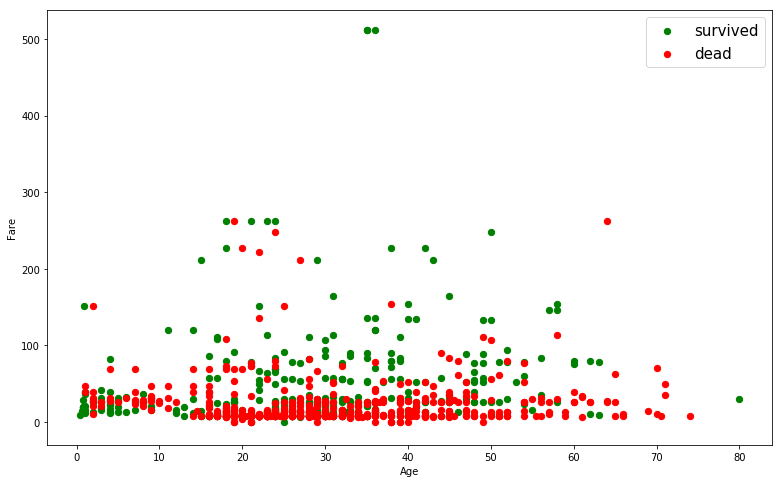

In [85]:
plt.figure(figsize=(13,8))
ax = plt.subplot()
ax.scatter(titanic_df[titanic_df['Survived']==1]['Age'],titanic_df[titanic_df['Survived']==1]['Fare'],c='green',s=40)
ax.scatter(titanic_df[titanic_df['Survived']==0]['Age'],titanic_df[titanic_df['Survived']==0]['Fare'],c='red',s=40)
ax.set_xlabel('Age')
ax.set_ylabel('Fare')
ax.legend(('survived','dead'),scatterpoints=1,loc='upper right',fontsize=15,)

The thick, red line of dots clustered around the bottom of the chart show's the worse position the cheaper ticket holders were in despite of age.

Now lets check survival per ticket class

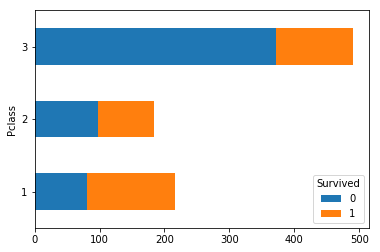

In [86]:
pd.crosstab(titanic_df['Pclass'], titanic_df['Survived']).plot.barh(stacked=True);

As above, there is strong correlation between more expensive tickets and improved survivability.

Survival per (calculated) ticket count:

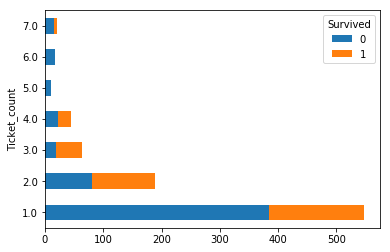

In [87]:
pd.crosstab(titanic_df['Ticket_count'], titanic_df['Survived']).plot.barh(stacked=True);

And survival per (calculated) family size

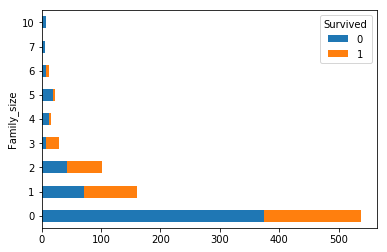

In [88]:
pd.crosstab(titanic_df['Family_size'], titanic_df['Survived']).plot.barh(stacked=True);

And, the overall correlation matrix, key column being the first, with correlation per feature against survivability:

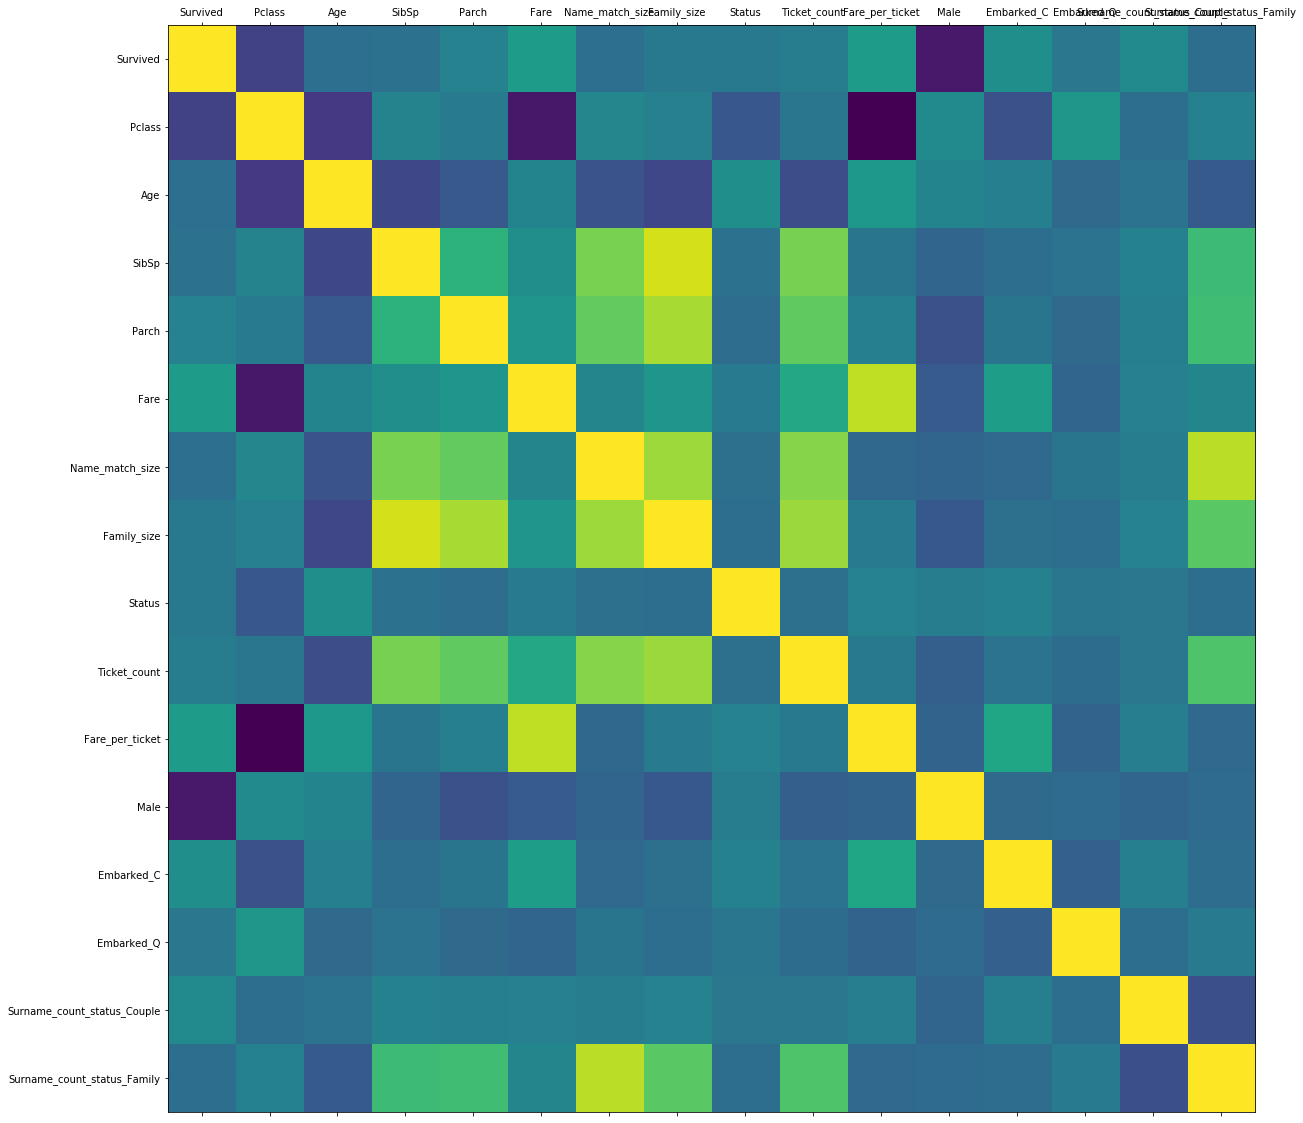

In [89]:
corr = pd.concat([y,X.iloc[:,0:15]], axis=1, join_axes=[X.index]).corr()
fig, ax = plt.subplots(figsize=(20, 20))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

## Part 3: Logistic Regression and Model Validation

#### 1. Define the variables that we will use in our classification analysis

In [90]:
Xv = X.values
yv = y.iloc[:,0].values

#### 2. Transform "Y" into a 1-Dimensional Array for SciKit-Learn

In [91]:
# done (to check: )
type(yv)

numpy.ndarray

#### 3. Conduct the logistic regression

In [92]:
logreg = LogisticRegression()
logreg.fit(Xv, yv)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### 4. Examine the coefficients to see our correlations

In [93]:
print 'Logreg intercept:', logreg.intercept_

Logreg intercept: [ 3.2847907]


In [94]:
#for col in X.columns:
#    print col
#for coef in pd.Series(logreg.coef_):
#    print coef
#for var,coef in zip(X.columns,logreg.coef_):
#    print var,coef

coefs = []

for featurename, coef in zip(X.columns,logreg.coef_[0]):
    coefs.append([featurename,coef])

coefs.sort(key=lambda x: x[1])

coefs

[['Male', -2.4968194375522259],
 ['Pclass', -0.71956810262865434],
 ['Cabin_letter_G', -0.50799902949398679],
 ['SibSp', -0.19554991195368868],
 ['Surname_count_status_Family', -0.19266560082190046],
 ['Cabin_letter_T', -0.18728684533266865],
 ['Family_size', -0.1193202144106706],
 ['Name_match_size', -0.074031740563335724],
 ['Age', -0.029797510555411303],
 ['Fare_per_ticket', -0.0017182665080570127],
 ['Fare', 0.0037446553101866636],
 ['Parch', 0.076229697543072572],
 ['Ticket_count', 0.095454985600191972],
 ['Status', 0.10830686941140924],
 ['Cabin_letter_C', 0.1228502943606562],
 ['Embarked_Q', 0.28254308356925523],
 ['Embarked_C', 0.4362252635357623],
 ['Cabin_letter_B', 0.46984094807745785],
 ['Surname_count_status_Couple', 0.48420000475079183],
 ['Cabin_letter_A', 0.50910329525362852],
 ['Cabin_letter_F', 0.9117676952836159],
 ['Cabin_letter_D', 0.91767321127122592],
 ['Cabin_letter_E', 1.2556816660957648]]

In [95]:
print 'Logreg predicted probabilities:', logreg.predict_proba(Xv[0:5,:])

Logreg predicted probabilities: [[ 0.86930931  0.13069069]
 [ 0.13669763  0.86330237]
 [ 0.40399814  0.59600186]
 [ 0.11809889  0.88190111]
 [ 0.87715302  0.12284698]]


In [96]:
correct = 0
incorrect = 0

for pred, actual in zip(logreg.predict_proba(Xv),yv):
    if (pred[0] >= 0.5 and actual == 0) or (pred[0] < 0.5 and actual == 1):
        correct += 1
    else:
        incorrect += 1

print "baseline = " + "62%"
print "correct: ", correct
print "incorrect: ", incorrect
print "accuracy = ", correct / float(correct+incorrect)

baseline = 62%
correct:  728
incorrect:  163
accuracy =  0.817059483726


#### 5. What are the risks and assumptions of our data? 

Assumptions: 
- Everything is correct data wise, including:
-  - My inputed/calculated values, such as matching the age via the surviver names on a seperate list, to the grouping of people by surname, which could group together people who simply matched name and didn't travel together
- - The data originally present in the data set, some of which is questionable - the age column, if it is missing in places, could be wrong in others? The family member on board data also looks suspicious

Risks:
- The number one risk is model overfitting - by fitting on all data, it could be too specific to the trip, and not accurately represent the outcome of another 1910's boat sinking.
- Overweighting on particular, very specific varibles, such as cabin letter designation, could well be inaccurate, given the small positive numbers involved, and thus the statistical reliability of the numbers.


#### 6. Test the Model by introducing a *Test* or *Validaton* set 

In [97]:
X_train, X_test, y_train, y_test = train_test_split(Xv, yv, test_size=0.5, random_state=2)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### 7. Predict the class labels for the *Test* set

In [98]:
yhat = logreg.predict(X_test)
print yhat[0:10]

[0 0 1 0 0 0 0 0 0 0]


#### 8. Predict the class probabilities for the *Test* set

In [99]:
yhat_pp = logreg.predict_proba(X_test)
print yhat_pp[0:10]

[[ 0.60483878  0.39516122]
 [ 0.87507342  0.12492658]
 [ 0.19413496  0.80586504]
 [ 0.89062652  0.10937348]
 [ 0.73537063  0.26462937]
 [ 0.89928524  0.10071476]
 [ 0.88088334  0.11911666]
 [ 0.88659575  0.11340425]
 [ 0.75462636  0.24537364]
 [ 0.82460195  0.17539805]]


#### 9. Evaluate the *Test* set

In [100]:
logreg.score(X_test, y_test)

0.82511210762331844

Not bad vs. the 62% baseline!

#### 10. Cross validate the test set

In [101]:
scores = cross_val_score(logreg, X_test, y_test, cv=5)
print scores
print np.mean(scores)

[ 0.75555556  0.80898876  0.80898876  0.84269663  0.76404494]
0.796054931336


#### 11. Check the Classification Report

In [102]:
#sklearn.metrics.classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2)
print classification_report(yhat,y_test)

             precision    recall  f1-score   support

          0       0.91      0.82      0.86       298
          1       0.70      0.83      0.76       148

avg / total       0.84      0.83      0.83       446



#### 12. What do the classification metrics tell us?

The model is disporportionally accurate at predicting the more frequent class (not surviving, or 0), determined by the precision of 0.91. 

Depending on the purpose of the model, for example assisting in disaster rescue or PR, one may want to adjust the thresholds in order to increase the true positives (or decrease them!) at the expense of other fields.

#### 13. Check the Confusion Matrix

Confusion matrix, without normalization
[[245  53]
 [ 25 123]]
Normalized confusion matrix
[[ 0.82214765  0.17785235]
 [ 0.16891892  0.83108108]]


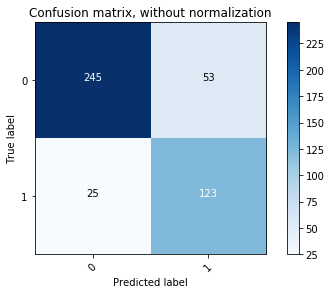

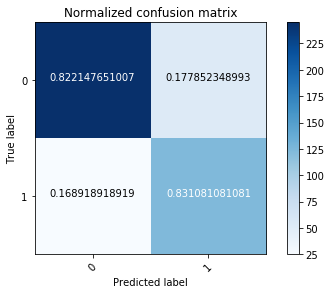

In [103]:
#confusion_matrix(yhat,y_test, labels=[0,1])

import itertools

cnf_matrix = confusion_matrix(yhat,y_test)

class_names = [0,1]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#sklearn.metrics.confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)



#### 14. What does the Confusion Matrix tell us? 

Similiar to the classification report, the model is more accurate at predicting deaths (0) than survivals (1), which will be partly because of the greater number of deaths in the dataset.

In terms of when the model guesses wrong, it is, in relative terms, more likely to falsely predict a death when someone survived, vs. a survival when someone died. This could be useful depending on the objective of the model (field recovery, insurance modelling, PR etc).

#### 15. Plot the ROC curve

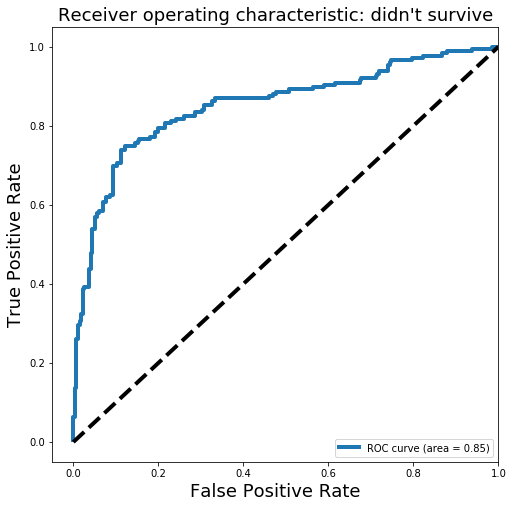

In [104]:
fpr, tpr, _ = roc_curve(y_test, yhat_pp[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: didn\'t survive', fontsize=18)
plt.legend(loc="lower right")
plt.show()

#### 16. What does the ROC curve tell us?

The model is somewhat far away from perfect classification! 

However, there is a fair amount of accuracy in the model given, and there would be a disproportionate increase in false positives, in order to increase the number of true positives.

There is certainly room for improvement in the model, but also opportunity to adjust the threshold in the existing one, depending on the unstated goals of the users.

## Part 5: Gridsearch

#### 1. Use GridSearchCV with logistic regression to search for optimal parameters 

- Use the provided parameter grid. Feel free to add if you like (such as n_jobs).
- Use 5-fold cross-validation.

In [105]:
logreg_parameters = {
    'penalty':['l1','l2'],
    'C':np.logspace(-5,2,500),
    'solver':['liblinear'],
    'n_jobs': [-1],
}

logreg = LogisticRegression()

logreggscv = GridSearchCV(logreg, logreg_parameters, verbose=1, cv=5)

logreggscv.fit(Xv, yv)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:   36.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.03283e-05, ...,   9.68215e+01,   1.00000e+02]), 'n_jobs': [-1], 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

#### 2. Print out the best parameters and best score. Are they better than the vanilla logistic regression?

In [106]:
print logreggscv.best_estimator_
print logreggscv.best_score_
print logreggscv.best_params_

LogisticRegression(C=0.95490445575180782, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.799102132435
{'penalty': 'l2', 'C': 0.95490445575180782, 'n_jobs': -1, 'solver': 'liblinear'}


Not much different from the vanilla regression.

Perhaps standardising the data can improve the results?

In [107]:
standard_scaler = StandardScaler()
Xvs = standard_scaler.fit_transform(Xv)
logreggscv.fit(Xvs, yv)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:   32.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.03283e-05, ...,   9.68215e+01,   1.00000e+02]), 'n_jobs': [-1], 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [108]:
print logreggscv.best_estimator_
print logreggscv.best_score_
print logreggscv.best_params_

LogisticRegression(C=0.31842416015046565, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.799102132435
{'penalty': 'l1', 'C': 0.31842416015046565, 'n_jobs': -1, 'solver': 'liblinear'}


No difference on the full variable set.

The query right now is using all variables - perhaps it is worth going back to the original model, and finding an optimum set?

As an experiment, lets try to brute force all five and six feature combinations to find a more effective original linear regression?

In [109]:
from itertools import combinations

In [110]:
x_columns = []

for column in X.columns:
    x_columns.append(str(column))

In [111]:
column_combination = []

five_combs = list(combinations(x_columns, 5))

print len(five_combs)

33649


In [112]:
results = []
for combo in five_combs:
    results.append([combo, np.mean(cross_val_score(logreg, X.loc[:,combo], yv, cv=5))])

In [113]:
print len(results)

33649


In [114]:
from operator import itemgetter

results_sorted = sorted(results, key=itemgetter(1))
print results_sorted[len(results)-1]

[('Pclass', 'Age', 'Name_match_size', 'Male', 'Cabin_letter_E'), 0.81032358117829462]


From the brute force linear regression, the best performance comes from previously identified variables.

Lets look for the variables, and score improvement, if six variables are searched through.

In [115]:
column_combination6 = []

six_combs = list(combinations(x_columns, 6))

results6 = []
for combo in six_combs:
    results6.append([combo, np.mean(cross_val_score(logreg, X.loc[:,combo], yv, cv=5))])

In [116]:
results_sorted6 = sorted(results6, key=itemgetter(1))
print results_sorted6[len(results6)-1]

[('Pclass', 'Age', 'Name_match_size', 'Male', 'Cabin_letter_D', 'Cabin_letter_E'), 0.81255814712245988]


In [117]:
column_combination52 = []

fivecombs = list(combinations(x_columns, 5))

results52 = []
for combo in five_combs:
    results52.append([combo, np.mean(cross_val_score(logreg, standard_scaler.fit_transform(X.loc[:,combo]), yv, cv=5))])
    
results_sorted52 = sorted(results52, key=itemgetter(1))
print results_sorted52[len(results52)-1]

[('Pclass', 'Family_size', 'Male', 'Surname_count_status_Family', 'Cabin_letter_F'), 0.80919984381799048]


Interestingly, five feature brute forcing on standardised data produces different variables, and a slightly slower score


The six feature logistic regression, with Class, Age, Name_match_size, Male, Cabin D and Cabin E comes out top. Can we can any extra accuracy by gridsearching with just these? First with standardistion, then without:

In [118]:
standard_scaler = StandardScaler()
Xvssix = standard_scaler.fit_transform(standard_scaler.fit_transform
(X.loc[:,['Pclass', 'Age', 'Name_match_size', 'Male', 'Cabin_letter_D', 'Cabin_letter_E']]))
logreggscv.fit(Xvssix, yv)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:   10.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.03283e-05, ...,   9.68215e+01,   1.00000e+02]), 'n_jobs': [-1], 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [119]:
print logreggscv.best_estimator_
print logreggscv.best_score_
print logreggscv.best_params_

LogisticRegression(C=4.5009751296080509, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.806958473625
{'penalty': 'l1', 'C': 4.5009751296080509, 'n_jobs': -1, 'solver': 'liblinear'}


In [120]:
Xvsix = X.loc[:,['Pclass', 'Age', 'Name_match_size', 'Male', 'Cabin_letter_D', 'Cabin_letter_E']]
logreggscv.fit(Xvsix, yv)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:   18.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.03283e-05, ...,   9.68215e+01,   1.00000e+02]), 'n_jobs': [-1], 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [121]:
print logreggscv.best_estimator_
print logreggscv.best_score_
print logreggscv.best_params_

LogisticRegression(C=0.64807198263119714, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.812570145903
{'penalty': 'l2', 'C': 0.64807198263119714, 'n_jobs': -1, 'solver': 'liblinear'}


So, we seem to have hit a performance ceiling at 81%, which is an improvement on the baseline.

Extra value could be possibly squeezed out by using other feature selection methods with the grid searching, but, other models should give more insight for the effort (and CPU cycles!)

#### 3. Explain the difference between the difference between the L1 (Lasso) and L2 (Ridge) penalties on the model coefficients.

The Ridge regression adds an additional component to the loss function: the sum of the squared (non-intercept!) $\beta$ values:

The Lasso regression takes a different approach - it adds the sum of the _absolute value_ of the $\beta$ coefficients:

Lasso deals primarily with the feature selection of valuable variables, eliminating ones that are not useful. This also takes care of multicollinearity, but in a different way: it will choose the "best" of the correlated variables and zero-out the other redundant ones. This is of course applicable to this project which has a variety of multicollinar features (e.g. ticket class, cabin position and fare).

#### 4. What hypothetical situations are the Ridge and Lasso penalties useful?

The Lasso and Ridge Net can be very useful for when you have redundant, or unimportant, variables. If you have dozens of variables in a dataset a Lasso can perform feature selection automatically for you by forcing coefficients to be zero.

#### 5.a. You decide that you want to minimize false positives. Use the predicted probabilities from the model to set your threshold for labeling the positive class to need at least 90% confidence. How and why does this affect your confusion matrix?

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X.loc[:,['Pclass', 'Age', 'Name_match_size', 'Male', 'Cabin_letter_D', 'Cabin_letter_E']], yv, test_size=0.5, random_state=2)

yhat = logreggscv.predict(X_test)
yhat_pp = logreggscv.predict_proba(X_test)
yhat_new_thresh = []

for yhat_ in yhat_pp:
    if yhat_[0] >= 0.9:
        yhat_new_thresh.append(0)
    else:
        yhat_new_thresh.append(1)
    
cnf_matrix = confusion_matrix(yhat_new_thresh,y_test)

print cnf_matrix

[[ 48   6]
 [222 170]]


Last confusion matrix, without normalization

[[239  51]

 [ 37 119]]

So, the revised threshold model has an extreme effect! The objective, to reduce false positives (incorrectly predicting survivors as dead), has been achieved - only three cases are falsely categorised.

The model also captures nearly all survivors - the number of true postives increases from 119 to 181.

The impact is negative on the other side though - correct predictions of deaths drops from 239 down to 48! And the model incorrectly predicts death in 214 cases where the person survived (37 to 214).

Overall, the misclassification rate/error rate has gone up from (37+51)/446 = 0.197 to (214+3)/446 = 0.48, which I would not consider positive for overall communication, or model performance.

## Part 5: Gridsearch and kNN

#### 1. Perform Gridsearch for the same classification problem as above, but use KNeighborsClassifier as your estimator

At least have number of neighbors and weights in your parameters dictionary.

In [123]:
from sklearn.neighbors import KNeighborsClassifier

knn_params={
    'weights':['uniform','distance'],
    'n_neighbors':range(1, 70, 4),
    'p':[1,2],
    "leaf_size": range(1, 101,4)
}

knn = KNeighborsClassifier()

knngs6 = GridSearchCV(knn, knn_params, verbose=1, cv=5)

Xvssix = standard_scaler.fit_transform(standard_scaler.fit_transform
(X.loc[:,['Pclass', 'Age', 'Name_match_size', 'Male', 'Cabin_letter_D', 'Cabin_letter_E']]))

knngs6.fit(Xvssix, yv)

print knngs6.best_estimator_
print knngs6.best_score_
print knngs6.best_params_

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
0.821548821549
{'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 5, 'p': 2}


[Parallel(n_jobs=1)]: Done 9000 out of 9000 | elapsed:  2.0min finished


In [124]:
knngs = GridSearchCV(knn, knn_params, verbose=1, cv=5)

Xvs = standard_scaler.fit_transform(standard_scaler.fit_transform(X))

knngs.fit(Xvs, yv)

print knngs.best_estimator_
print knngs.best_score_
print knngs.best_params_

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=1,
           weights='uniform')
0.810325476992
{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 1, 'p': 1}


[Parallel(n_jobs=1)]: Done 9000 out of 9000 | elapsed:  5.4min finished


#### 2. Print the best parameters and score for the gridsearched kNN model. How does it compare to the logistic regression model?

In [125]:
print knngs6.best_estimator_
print knngs6.best_score_
print knngs6.best_params_

KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
0.821548821549
{'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 5, 'p': 2}


The six feature gridsearched kNN model has approximately 1% higher score - enough to give hope that we can find better models with more applications and tuning.

Interestingly, the kNN on the previously chosen half dozen feature set outperforms the model on all features. Intuitively this makes sense due to overfitting on the broader model.

#### 3. How does the number of neighbors affect the bias-variance tradeoff of your model?

#### Why?

Increasing k will decrease variance and increase bias, whilst decreasing k will increase variance and decrease bias.

The bias term is a function of how rough the model space is (e.g. how quickly in reality do values change as we move through the space of different wealths and religiosities). The rougher the space, the faster the bias term will increase as further away neighbors are brought into estimates.



#### 4. In what hypothetical scenario(s) might you prefer logistic regression over kNN, aside from model performance metrics?

* Because Logistic Regression gives a probabilty, not a binary classification, it means the thresholds can be adjusted (as we saw above)

* Theoretically, given a simple enough logistic model (probably without standardised input), it could be performed on a calculator with paper - it can be an interpretable model. KNN is very difficult to manually implement on paper.

* Because of this simplicity of explanation/notation/implementation, it might be prefered by certain recipeients who want complete transparency of process.

* Sharing a kNN model requires sharing the training data - if this was confidential, one could not share an accurately trained model.

#### 5. Fit a new kNN model with the optimal parameters found in gridsearch. 

In [126]:
#GridSearchCV implements a “fit” and a “score” method.
#It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

knnb = KNeighborsClassifier(n_neighbors= 7, weights = 'uniform', leaf_size = 13, p = 2)

knnb.fit(standard_scaler.fit_transform(X_train), y_train)

yhat = knnb.predict(standard_scaler.transform(X_test))
yhat_pp = knnb.predict_proba(standard_scaler.transform(X_test))

#### 6. Construct the confusion matrix for the optimal kNN model. Is it different from the logistic regression model? If so, how?

In [127]:
cnf_matrix = confusion_matrix(yhat,y_test)
standard_scaler.fit(X_train)
yhat_pp = knnb.predict_proba(standard_scaler.transform(X_test))
print cnf_matrix

[[247  56]
 [ 23 120]]


Original Confusion matrix
[[239  51]
 [ 37 119]]

The gridsearch kNN have improved the True Positives (119 -> 121) and the True Negatives (239 -> 247)

The overall accuracy of (247+121)/(230+79+40+97) of 0.825 is an improvement over the original confusion matrix' .80

The False Positive rate has actually increased though - 55/(247+55) 0.18 from 0.175, so it doesn't hit one of the potential requests from the customer.

#### 7. Plot the ROC curves for the optimized logistic regression model and the optimized kNN model on the same plot.

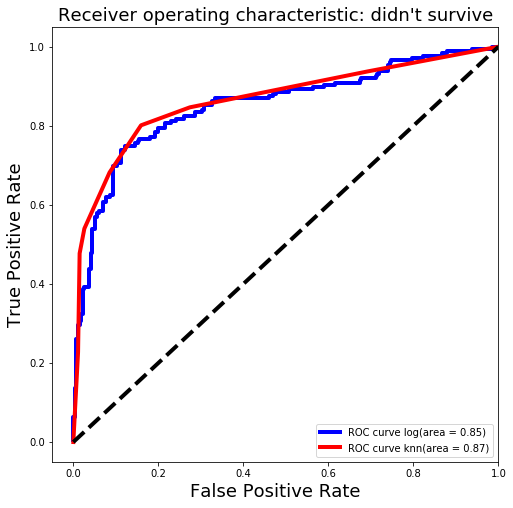

In [128]:
fpr2, tpr2, _ = roc_curve(y_test, yhat_pp[:,1])
roc_auc2 = auc(fpr2, tpr2)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve log(area = %0.2f)' % roc_auc, linewidth=4,color='blue')
plt.plot(fpr2, tpr2, label='ROC curve knn(area = %0.2f)' % roc_auc2, linewidth=4,color='red')


plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: didn\'t survive', fontsize=18)
plt.legend(loc="lower right")
plt.show()

## Part 6: Precision-recall

#### 1. Gridsearch the same parameters for logistic regression but change the scoring function to 'average_precision'

`'average_precision'` will optimize parameters for area under the precision-recall curve instead of for accuracy.

In [129]:
Xvs = standard_scaler.fit_transform(X.loc[:,['Pclass', 'Age', 'Name_match_size', 'Male', 'Cabin_letter_D', 'Cabin_letter_E']])

X_train, X_test, y_train, y_test = train_test_split(Xvs, yv, test_size=0.5, random_state=2)

logreg_parameters = {
    'penalty':['l1','l2'],
    'C':np.logspace(-5,2,500),
    'solver':['liblinear'],
    'n_jobs': [-1],
}

logreg = LogisticRegression()

logreggscva = GridSearchCV(logreg, logreg_parameters, verbose=1, cv=5,scoring='average_precision')

logreggscva.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:   12.0s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.03283e-05, ...,   9.68215e+01,   1.00000e+02]), 'n_jobs': [-1], 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='average_precision', verbose=1)

#### 2. Examine the best parameters and score. Are they different than the logistic regression gridsearch in part 5?

In [130]:
print logreggscva.best_estimator_
print logreggscva.best_score_
print logreggscva.best_params_

LogisticRegression(C=0.23052893870517108, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.822360003997
{'penalty': 'l1', 'C': 0.23052893870517108, 'n_jobs': -1, 'solver': 'liblinear'}


LogisticRegression(C=0.64807198263119714, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.812570145903
{'penalty': 'l2', 'C': 0.64807198263119714, 'n_jobs': -1, 'solver': 'liblinear'}

The penalty has changed from L2 to L1, with a lower C (0.23 down from 0.64). The reported score has improved.

#### 3. Create the confusion matrix. Is it different than when you optimized for the accuracy? If so, why would this be?

In [132]:
yhat = logreggscva.predict(X_test)
cnf_matrix = confusion_matrix(yhat,y_test)

print cnf_matrix

[[236  51]
 [ 34 125]]


(Previously)Confusion matrix, without normalization
[[245  53]
 [ 25 123]]

Total accuracy (TP+TN)/(all) is down - 0.809 vs. 0.825, despite the score we were given being higher.

This is because the 'average_precision' score gives the area under the ROC curve - this means we could potentially alter the threshold of this model and get better results than the same threshold changes on the earlier model.

#### 4. Plot the precision-recall curve. What does this tell us as opposed to the ROC curve?

[See the sklearn plotting example here.](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

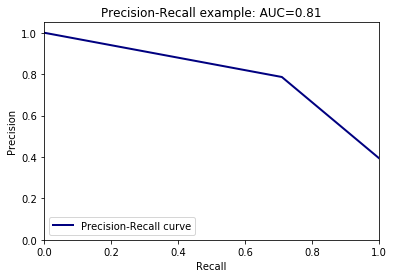

In [134]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from itertools import cycle



y_test_b = label_binarize(y_test, classes=[0, 1])
yhat_b = label_binarize(yhat, classes=[0, 1])
n_classes = y_test_b.shape[1]

precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_b[:, i], yhat_b[:, i])
    average_precision[i] = average_precision_score(y_test_b[:, i], yhat_b[:, i])
    
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
lw = 2

# Plot Precision-Recall curve

plt.clf()
plt.plot(recall[0], precision[0], lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
plt.legend(loc="lower left")
plt.show()

The curve shows us how recall increases per decrease in precision for a given model.

It can be useful for a single model, but it can also help in the selection between two models, given the customer's requirements of precision and recall

## Part 8: Decision trees, ensembles, bagging

#### 1. Gridsearch a decision tree classifier model on the data, searching for optimal depth. Create a new decision tree model with the optimal parameters.

In [135]:
dtree=DecisionTreeClassifier()

decision_tree_params={
    'max_features':['auto','sqrt','log2',None],
    'max_depth':[None,1,2,3,4,5,6,7],
    'min_samples_split':range(2,80)
}

dtreegs=GridSearchCV(dtree,decision_tree_params,cv=5,verbose=1)

dtreegs.fit(X_train,y_train)

Fitting 5 folds for each of 2496 candidates, totalling 12480 fits


[Parallel(n_jobs=1)]: Done 12480 out of 12480 | elapsed:   21.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto', 'sqrt', 'log2', None], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79], 'max_depth': [None, 1, 2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [136]:
print dtreegs.best_estimator_
print dtreegs.best_score_
print dtreegs.best_params_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
0.833707865169
{'max_features': 'auto', 'min_samples_split': 50, 'max_depth': None}


In [137]:
dtreebest=DecisionTreeClassifier(max_features='log2', min_samples_split=45, max_depth= None)
dtreebest.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=45, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

#### 2. Compare the performace of the decision tree model to the logistic regression and kNN models.

In [138]:
dtreebest.score(X_test,y_test)

0.80269058295964124

At a score of 0.80, the decision three is competitive with, but not beating the optimised logistic and knn models.

#### 3. Plot all three optimized models' ROC curves on the same plot. 

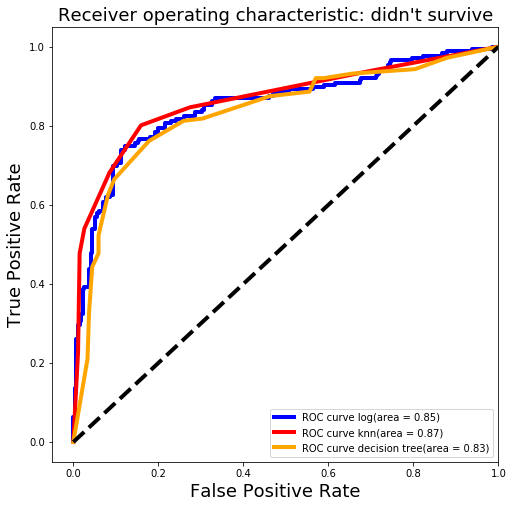

In [139]:
yhat_pp = dtreebest.predict_proba(X_test)

fpr3, tpr3, _ = roc_curve(y_test, yhat_pp[:,1])
roc_auc3 = auc(fpr3, tpr3)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve log(area = %0.2f)' % roc_auc, linewidth=4,color='blue')
plt.plot(fpr2, tpr2, label='ROC curve knn(area = %0.2f)' % roc_auc2, linewidth=4,color='red')
plt.plot(fpr3, tpr3, label='ROC curve decision tree(area = %0.2f)' % roc_auc3, linewidth=4,color='orange')

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: didn\'t survive', fontsize=18)
plt.legend(loc="lower right")
plt.show()

#### 4. Use sklearn's BaggingClassifier with the base estimator your optimized decision tree model. How does the performance compare to the single decision tree classifier?

In [140]:
bag = BaggingClassifier(base_estimator = dtreebest)

bag.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=45, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [141]:
bag.score(X_test,y_test)

0.81390134529147984

It is performing in line with others, without any optimisation

#### 5. Gridsearch the optimal n_estimators, max_samples, and max_features for the bagging classifier.

In [142]:
bc_params={'n_estimators':range(2,30),
           'max_samples':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
           'max_features':[0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0],
           'bootstrap':[True,False],
           'bootstrap_features':[True,False],
}

bcgs=GridSearchCV(bag,bc_params,cv=5,verbose=1)

bcgs.fit(X_train, y_train)

Fitting 5 folds for each of 12320 candidates, totalling 61600 fits


[Parallel(n_jobs=1)]: Done 61600 out of 61600 | elapsed: 26.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=45, min_weight_fraction_leaf=0.0,
     ...n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'bootstrap': [True, False], 'bootstrap_features': [True, False], 'max_features': [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [143]:
print bcgs.best_estimator_
print bcgs.best_score_
print bcgs.best_params_

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=45, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=False, bootstrap_features=True, max_features=0.95,
         max_samples=0.5, n_estimators=20, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)
0.838202247191
{'max_features': 0.95, 'max_samples': 0.5, 'bootstrap': False, 'n_estimators': 20, 'bootstrap_features': True}


#### 6. Create a bagging classifier model with the optimal parameters and compare it's performance to the other two models.

In [144]:
bagbest = BaggingClassifier(base_estimator = dtreebest,max_features= 0.95, max_samples= 0.8,
                            bootstrap= False, n_estimators= 13, bootstrap_features= False)

bagbest.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=45, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=False, bootstrap_features=False, max_features=0.95,
         max_samples=0.8, n_estimators=13, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [145]:
bagbest.score(X_test,y_test)

0.81165919282511212

In [146]:
print bagbest.score(X_test,y_test)
yhat = bagbest.predict(X_test)
yhat_pp = bagbest.predict_proba(X_test)
cnf_matrix = confusion_matrix(yhat,y_test)
print cnf_matrix

0.811659192825
[[242  56]
 [ 28 120]]


This is the best score yet, narrowly edging out the previous decision tree.

It has the highest True negative total to date, and thus the highest specificity and accuracy.

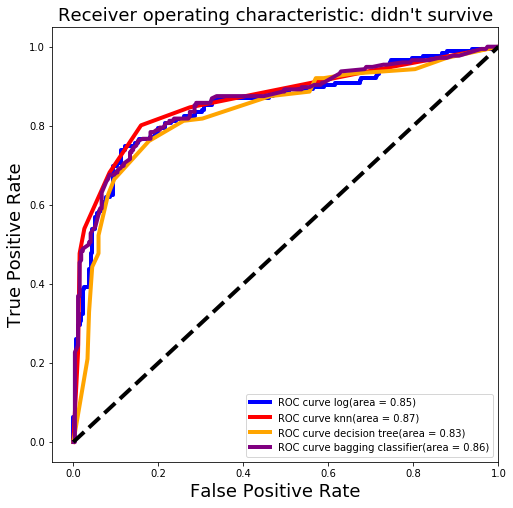

In [147]:
fpr4, tpr4, _ = roc_curve(y_test, yhat_pp[:,1])
roc_auc4 = auc(fpr4, tpr4)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve log(area = %0.2f)' % roc_auc, linewidth=4,color='blue')
plt.plot(fpr2, tpr2, label='ROC curve knn(area = %0.2f)' % roc_auc2, linewidth=4,color='red')
plt.plot(fpr3, tpr3, label='ROC curve decision tree(area = %0.2f)' % roc_auc3, linewidth=4,color='orange')
plt.plot(fpr4, tpr4, label='ROC curve bagging classifier(area = %0.2f)' % roc_auc4, linewidth=4,color='purple')

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: didn\'t survive', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Project Conclusion

I believe we can say that the null hypothesis has been disproven - people were not equally likely to survive the titanic disaster.

The factors which particularly drove my models were the following:

['Pclass', 'Age', 'Name_match_size', 'Male', 'Cabin_letter_D', 'Cabin_letter_E']

Higher class tickets, lower age, smaller groups, not being male, and staying in cabin D or E all helped towards survival.

People with the opposites of those variables had a very tough time (but, not all!)

All models peaked in the low eigthies in accuracy, which is an improvement on the 62% baseline.

The bagging classifier had the most success, but, at the expense of transparency and human understanding. The decision tree, and logistic regression, got close in terms of accuracy, and would be easier to explain to people, and implement on a simpler IT system.

Lastly, false positives, and false negatives, can be reduced, but at the expense of other confusion matrix KPIs. If control of a particular KPI is important, the ROC curves, above, can be consulted to pick a model which is most complementary to the project's target